In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from synthetic_datasets import BatchedInContextRecallDataset
from meta_optimizers import MetaSGD
from memory_module import inner_optimization_forward, TTT
from model_components import HyperparamModel, LearnableHyperparam
from evaluate import compute_recall_accuracies, correct_retrieval_counts_by_timestep, average_accuracy_by_offset

In [2]:
key_dim=10
val_dim=10
context_size=5 # inner loss computation window
seq_len=100
batch_size=100
output_corr=0
inner_optimizer=MetaSGD()
#inner_optimizer_kwargs={ "beta": torch.tensor(0.9)}
#outer_optimizer_kwargs={"lr": 0.01}

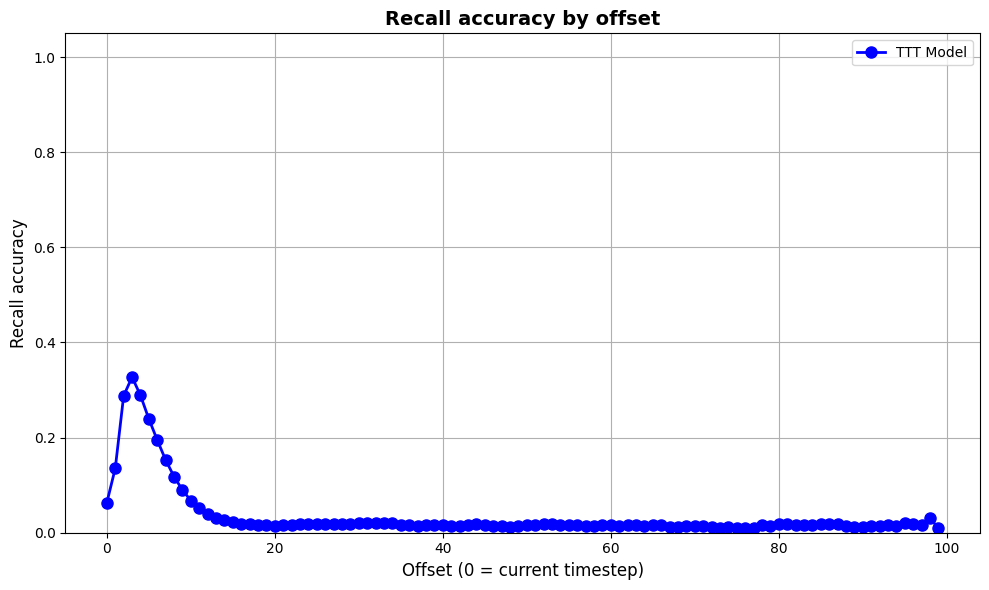

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = BatchedInContextRecallDataset(
    seq_len=seq_len,
    key_dim=key_dim,
    val_dim=val_dim,
    context_size=context_size,
    batch_size=batch_size,
)    

_, predictions = inner_optimization_forward(
    memory_module=TTT(key_dim,val_dim,1, 0.0).to(device),
    dataset=dataset.to(device),
    inner_opt=inner_optimizer,
    lr_head=0.1,
    loss_weight_head=torch.ones(context_size).to(device),
    eval_mode=True
)

accuracies = compute_recall_accuracies(predictions,dataset.targets)
accuracy_by_offset, count = average_accuracy_by_offset(accuracies)


# Convert dictionary to arrays for proper plotting
offsets = np.arange(len(accuracy_by_offset))
accuracies_array = accuracy_by_offset.to("cpu")

# Plot average accuracy by offset
plt.figure(figsize=(10, 6))
plt.plot(offsets, accuracies_array, 'bo-', linewidth=2, markersize=8, label='TTT Model')
plt.xlabel("Offset (0 = current timestep)", fontsize=12)
plt.ylabel("Recall accuracy", fontsize=12)
plt.title("Recall accuracy by offset", fontsize=14, fontweight='bold')
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pickle

# Load a pickle file
with open('/home/omni/Documents/programming_projects/old_ICR/old_commit/src/saved_results/all_datasets.pkl', 'rb') as f:
    data = pickle.load(f)

all_inputs = data["inputs"]
all_targets = data["targets"]

with open("saved_results/accuracy_histories_lr_0.1.pkl", "rb") as f:
    old_accuracy_histories = pickle.load(f)